
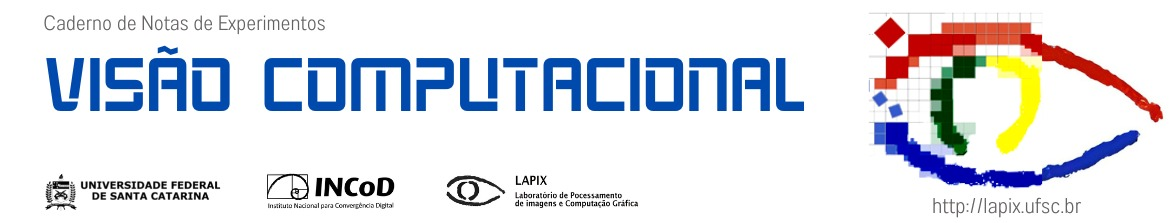






<a href="https://colab.research.google.com/github/awangenh/vision/blob/master/jupyter/03.2.kNN%20-%20Similaridde%20como%20Dist%C3%A2ncia%20entre%20Imagens%20.ipynb"><img align="left"  src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>&nbsp; &nbsp;<a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/License-CC-BY-ND-4.0-orange.png" alt="Creative Commons 4.0 License" title="Creative Commons 4.0 License"></a>&nbsp; &nbsp; <a href=""><img align="left" src="http://www.lapix.ufsc.br/wp-content/uploads/2019/04/Jupyter-Notebook-v.1.0-blue.png" alt="Jupyter Version" title="Jupyter Version"></a>&nbsp; &nbsp;<a href=""><img align="left"  src="https://img.shields.io/badge/python-3.10-greeng" alt="Python Version" title="Python Version"></a>


# 03.2.kNN - Similaridade como Distância entre Imagens

Neste caderno de notas aqui nós vamos ver um exercício que é originário da disciplina de Visão Computacional com Aprendizado Profundo (cs231) da Universidade de Stanford nos Estados Unidos. Este curso foi inicialmente concebido e ministrado por Andrej Karpathy, que foi diretor de Inteligência Artificial da Tesla até 2021. Se você quer olhar a estrutura atual do curso e saber se ele vai ser oferecido este ano acesse este link: http://cs231n.stanford.edu/schedule.html 

No exercício adiante você vai inicialmente criar um "banco de dados" de imagens-protótipo e depois, usando o método dos k-vizinhos mais próximos, classificar novas imagens por pura similaridade de pixels. 

Do ponto de vista da "classificação de uma imagem a partir da compreensão do seu conteúdo" o código adiante é profundamente errado: estamos usando o método de força bruta que simplesmente avalia quantos pixels parecidos existem entre duas imagens, sem absolutamente levar em consideração qualquer tipo de estrutura dentro das imagens. O método é de força bruta porque eu necessariamente tenho que comparar toda nova imagem com todas as outras no meu conjunto de treino. 

O mais surpreendente, porém, é que os resultados que se obtém aplicando este enfoque são inesperadamente pouco ruins… Você possui uma hipótese de por quê isso ocorre?

 * https://github.com/MahanFathi

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

# Configurações GPU e PATH

In [4]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!nvcc --version

try:
    import google.colab
    _ON_COLAB = True
except:
    _ON_COLAB = False

print('Running on Google Colab = ', _ON_COLAB)
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

import os
# Definir o caminho base
if _ON_COLAB:
    BASE_PATH = "/content"
    CS231_PATH = "/content"
    DATASET_PATH = "/content/CS231/assignment1/cs231n/datasets"
    import locale
    locale.getpreferredencoding = lambda: "UTF-8"
else:
    BASE_PATH = "/lapix" # trocar para o base path do seu computador se estiver rodando localmente, deixar /lapix se estiver rodando nos conteiners lapix
    CS231_PATH = "/lapix/compartilhado"
    VISIBLE_GPUS = [7] # Selecionar a GPU PARA RODAR! VER QUAL ESTA LIVRE

    if torch.cuda.device_count() != 8:
        print("GPU SETADA - PULANDO ETAPA")
    else:
        os.environ["CUDA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        os.environ["NVIDIA_VISIBLE_DEVICES"] = str(VISIBLE_GPUS).replace("]", "").replace("[","").replace(" ", "")
        print("CUDA GPUS NUMBER: ", torch.cuda.device_count())
    
os.chdir(BASE_PATH) # garantir que está executando no caminho base definido

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Mar_28_02:18:24_PDT_2024
Cuda compilation tools, release 12.4, V12.4.131
Build cuda_12.4.r12.4/compiler.34097967_0
Running on Google Colab =  False
GPU SETADA - PULANDO ETAPA


In [5]:
import os
# Colab specific configuration
if _ON_COLAB:
    # download CS231 GIT
    !git clone https://github.com/MahanFathi/CS231.git
    os.chdir(DATASET_PATH)
    # download cifar10
    !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
    !tar -xzf cifar-10-python.tar.gz
    os.chdir(BASE_PATH)
    # update data_utils
    target = 'from scipy.misc import imread'
    replacer = 'from cv2 import imread\n'
    data_utils = "/content/CS231/assignment1/cs231n/data_utils.py"
    idx_del = None
    with open(data_utils, 'r') as infile:
        new_data = infile.readlines()
        for i, line in enumerate(new_data):
            if target in line:
                new_data[i] = replacer
    
    with open(data_utils, 'w', encoding='utf-8') as outfile:
        outfile.writelines(new_data)

In [6]:
# Load the raw CIFAR-10 data.
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
if _ON_COLAB:
    sys.path.insert(1, os.path.join(CS231_PATH, "CS231/assignment1"))
    from cs231n.data_utils import load_CIFAR10
    cifar10_dir = os.path.join(DATASET_PATH, "cifar-10-batches-py")
else:
    sys.path.insert(1, os.path.join(CS231_PATH, "CS231/assignment1/cs231n"))
    from data_utils import load_CIFAR10
    cifar10_dir = os.path.join(CS231_PATH, "CS231/assignment1/cs231n/datasets/cifar-10-batches-py")


X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


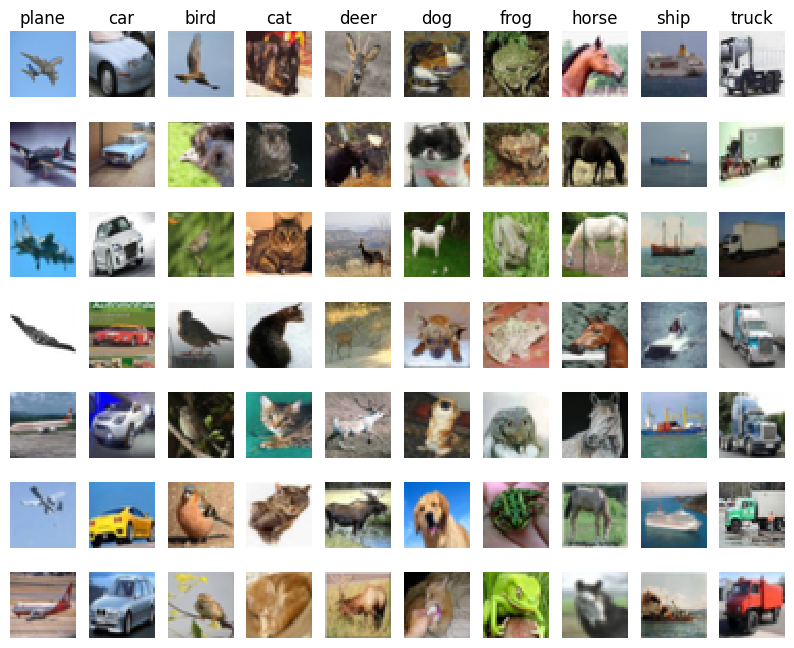

In [7]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [8]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

In [9]:
X_train.shape

(5000, 32, 32, 3)

In [10]:
# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [11]:
if _ON_COLAB:
    sys.path.insert(1, os.path.join(CS231_PATH, "CS231/assignment1"))
    from cs231n.classifiers import KNearestNeighbor
else:
    sys.path.insert(1, os.path.join(CS231_PATH, "CS231/assignment1/cs231n"))
    from classifiers import KNearestNeighbor


# Create a kNN classifier instance. 
# Remember that training a kNN classifier is a noop: 
# the Classifier simply remembers the data and does no further processing 
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps: 

1. First we must compute the distances between all test examples and all train examples. 
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [12]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


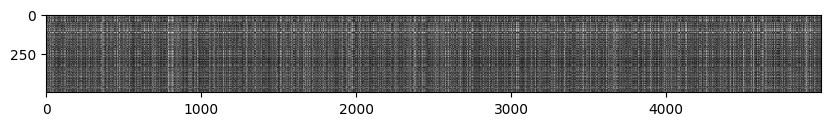

In [13]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

**Inline Question #1:** Notice the structured patterns in the distance matrix, where some rows or columns are visible brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

**Your Answer**: *fill this in.*



In [14]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [16]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 145 / 500 correct => accuracy: 0.290000


You should expect to see a slightly better performance than with `k = 1`.

In [17]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [18]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('Difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

Difference was: 0.000000
Good! The distance matrices are the same


In [19]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# you should see significantly faster performance with the fully vectorized implementation

Two loop version took 9.723034 seconds
One loop version took 45.209161 seconds
No loop version took 0.074328 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [20]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################

X_train_folds = np.split(X_train, num_folds)
y_train_folds = np.split(y_train, num_folds)

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}
num_split = X_train.shape[0] / num_folds
acc_k = np.zeros((len(k_choices), num_folds), dtype=np.float64)

################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################

for ik ,k in enumerate(k_choices):
    for i in range(num_folds):
        train_set = np.concatenate((X_train_folds[:i]+X_train_folds[i+1:]))
        label_set = np.concatenate((y_train_folds[:i]+y_train_folds[i+1:]))
        classifier.train(train_set, label_set)
        y_pred_fold = classifier.predict(X_train_folds[i], k=k, num_loops=0)
        num_correct = np.sum(y_pred_fold == y_train_folds[i])
        acc_k[ik, i] = float(num_correct) / num_split
    k_to_accuracies[k] = acc_k[ik]

################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.263000
k = 1, accuracy = 0.257000
k = 1, accuracy = 0.264000
k = 1, accuracy = 0.278000
k = 1, accuracy = 0.266000
k = 3, accuracy = 0.257000
k = 3, accuracy = 0.263000
k = 3, accuracy = 0.273000
k = 3, accuracy = 0.282000
k = 3, accuracy = 0.270000
k = 5, accuracy = 0.265000
k = 5, accuracy = 0.275000
k = 5, accuracy = 0.295000
k = 5, accuracy = 0.298000
k = 5, accuracy = 0.284000
k = 8, accuracy = 0.272000
k = 8, accuracy = 0.295000
k = 8, accuracy = 0.284000
k = 8, accuracy = 0.298000
k = 8, accuracy = 0.290000
k = 10, accuracy = 0.272000
k = 10, accuracy = 0.303000
k = 10, accuracy = 0.289000
k = 10, accuracy = 0.292000
k = 10, accuracy = 0.285000
k = 12, accuracy = 0.271000
k = 12, accuracy = 0.305000
k = 12, accuracy = 0.285000
k = 12, accuracy = 0.289000
k = 12, accuracy = 0.281000
k = 15, accuracy = 0.260000
k = 15, accuracy = 0.302000
k = 15, accuracy = 0.292000
k = 15, accuracy = 0.292000
k = 15, accuracy = 0.285000
k = 20, accuracy = 0.268000
k = 20, accu

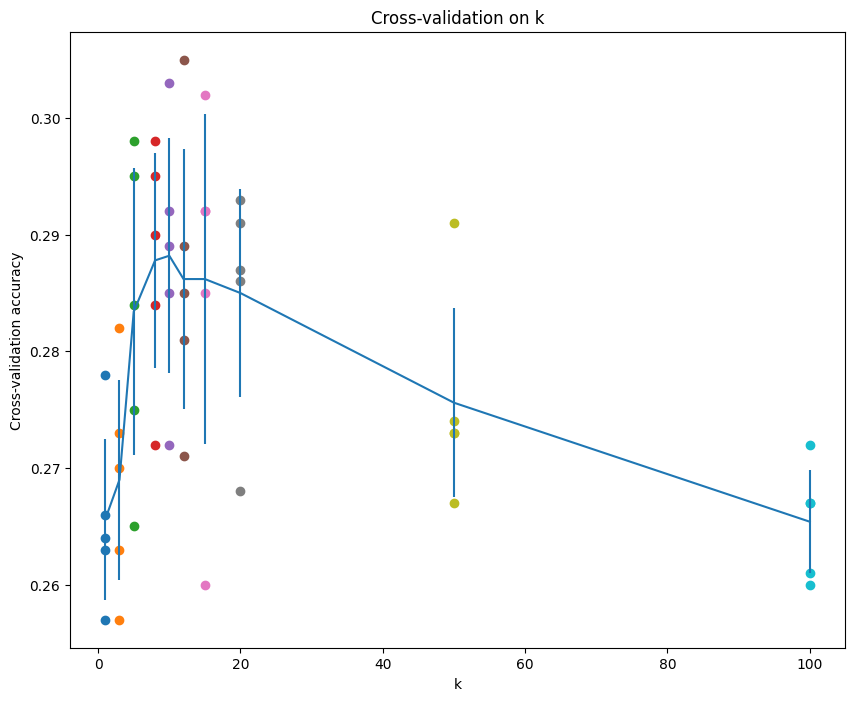

In [21]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [22]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 144 / 500 correct => accuracy: 0.288000


![rodape lapix ufsc](../rodape-CC.png)